## Setup the default forcing

In [1]:
from matplotlib import rc
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
import shutil
from pathlib import Path
os.chdir("/home/149/ab8992/topographic-NIWs")
basepath = Path.cwd().absolute()

import autolib as al
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34239,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:41803,Total threads: 4
Dashboard: /proxy/39727/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:42429,


In [2]:
def postprocess(expt):
    basepath = Path("/home/149/ab8992/topographic-NIWs/rundirs") / expt.split("_")[0] / expt / "archive/*"

    u = xr.open_mfdataset(str(basepath) + "/u.nc", decode_times = False,decode_cf = False).sel(yh = slice(-250,250)).sel(xq = 250,method = "nearest").u.load()
    ufar = xr.open_mfdataset(str(basepath) + "/u.nc", decode_times = False,decode_cf = False).sel(yh = slice(-250,250)).isel(xq = 0).u.load()
    v = xr.open_mfdataset(str(basepath) + "/v.nc", decode_times = False,decode_cf = False).sel(xh = slice(-250,250)).sel(yq = 250,method = "nearest").v.load()

    eEastFar = xr.open_mfdataset(str(basepath) + "/e.nc", decode_times = False,decode_cf = False).sel(yh = slice(-250,250)).isel(xh = 0).e.load()

    eEast = xr.open_mfdataset(str(basepath) + "/e.nc", decode_times = False,decode_cf = False).sel(yh = slice(-250,250)).sel(xh = 250,method = "nearest").e.load()
    eNorth = xr.open_mfdataset(str(basepath) + "/e.nc", decode_times = False,decode_cf = False).sel(xh = slice(-250,250)).sel(yh = 250,method = "nearest").e.load()

    pEast = al.calculate_pressure(eEast,u.zl)
    pEastFar = al.calculate_pressure(eEastFar,u.zl)
    pNorth = al.calculate_pressure(eNorth,u.zl)

    pEast = pEast - pEast.isel(time = 0)
    pEastFar = pEastFar - pEastFar.isel(time = 0)
    pNorth = pNorth - pNorth.isel(time = 0)

    out = xr.merge([u - ufar,v,(pEast - pEastFar).rename("pEast"),pNorth.rename("pNorth")]).load()
    outpath = Path("/g/data/v45/ab8992/bottom-niws-outputs/sept2024-bniw-outputs/") / expt.split("_")[0] / expt
    if not os.path.exists(outpath):
        os.makedirs(outpath)
    out.to_netcdf(outpath / f"{expt}_0.nc")
    return 

data = {}
for strength in [0.2,0.5,0.75,1.25,1.5,2,3,4,10,12,15,20] + [5,6,7,8,9]:
    data[f"strength_{strength}"] = postprocess(f"strength_{strength}")


In [5]:
data = {}
for strength in [0.2,0.5,0.75,1.25,1.5,2,3,4,10,12,15,20] + [5,6,7,8,9]:
    expt = "strength_" + str(strength)
    data[expt] = xr.open_dataset(
        Path("/g/data/v45/ab8992/bottom-niws-outputs/sept2024-bniw-outputs/") / expt.split("_")[0] / expt / f"{expt}_0.nc",
        decode_times = False,decode_cf = False)

## Plot EF for each strength

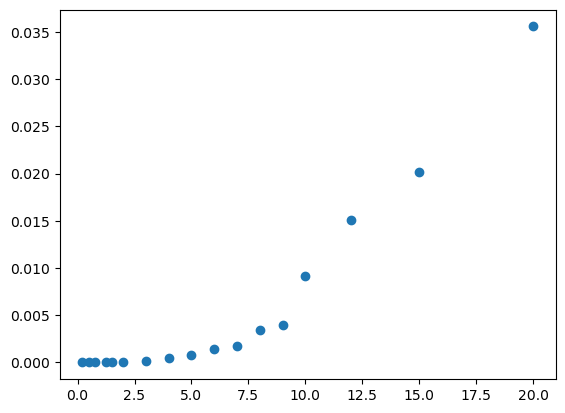

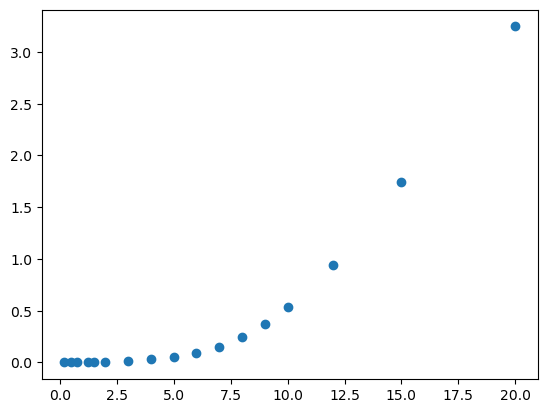

In [10]:
def ef_mean(data):
    u = data.u
    v = data.v
    pEast = data.pEast
    pNorth = data.pNorth
    endtime = int(u.time[-1].values)
    ztot = 4000 * 1000 * (u * pEast).sum("zl").integrate("time").integrate("yh").values
    mtot = 4000 * 1000 * (v * pNorth).sum("zl").integrate("time").integrate("xh").values


    zmean = ztot / (endtime * 500000 * 12500)
    mmean = mtot / (endtime * 500000 * 100000)
    return zmean,mmean

xax = []
yax1 = []
yax2 = []
for expt in data:
    xax.append(float(expt.split("_")[1]))
    a,b = ef_mean(data[expt])
    yax1.append(a)
    yax2.append(b)

xax,yax1,yax2 = np.array(xax),np.array(yax1),np.array(yax2)

plt.scatter(xax,yax1)
plt.figure()
plt.scatter(xax,yax2)


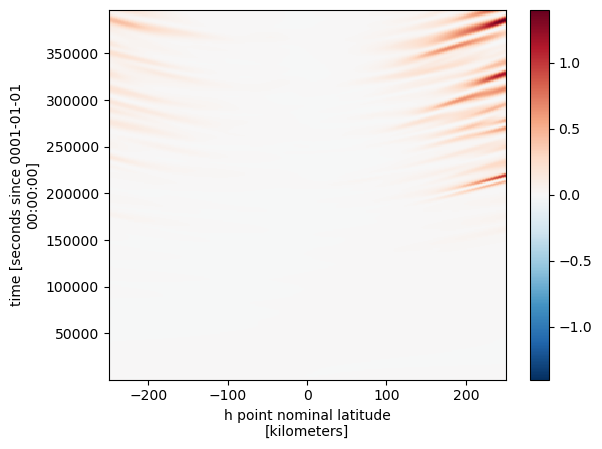

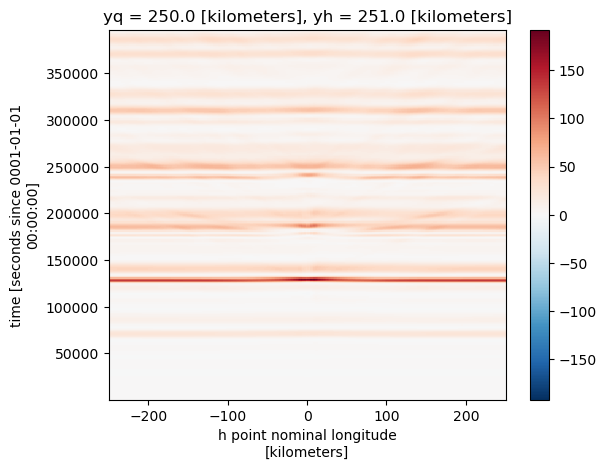

In [30]:


((u - ufar) * (pEast - pEastFar)).sum("zl").plot()
plt.figure()
(v * pNorth).sum("zl").plot()


In [53]:
endtime = int(u.time[-1].values)


In [58]:
# 4000m depth * 1000 conversion to m

ztot = 4000 * 1000 * ((u - ufar) * (pEast - pEastFar)).sum("zl").integrate("time").integrate("yh").values
mtot = 4000 * 1000 * (v * pNorth).sum("zl").integrate("time").integrate("xh").values

zmean = ztot / (endtime * 500000 * 12500)
mmean = mtot / (endtime * 500000 * 100000)

print("average Wm2 zonal: ",zmean)
print("average Wm2 merid: ",mmean)

print("percentage diff: ",100 * zmean / mmean)

average Wm2 zonal:  0.009115768440337386
average Wm2 merid:  0.5354498810619603
percentage diff:  1.7024503623491405


In [36]:
mtot

array(2.65047691e+09)

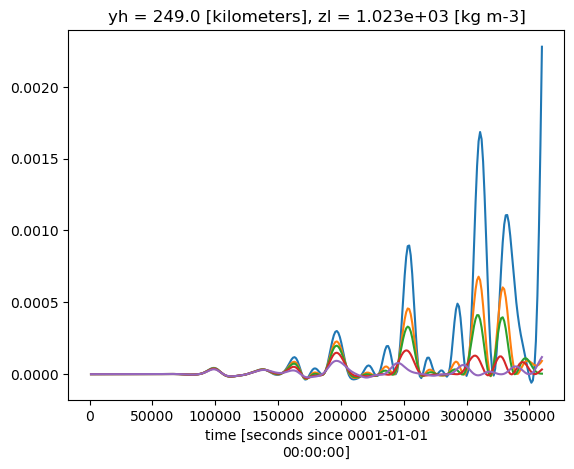

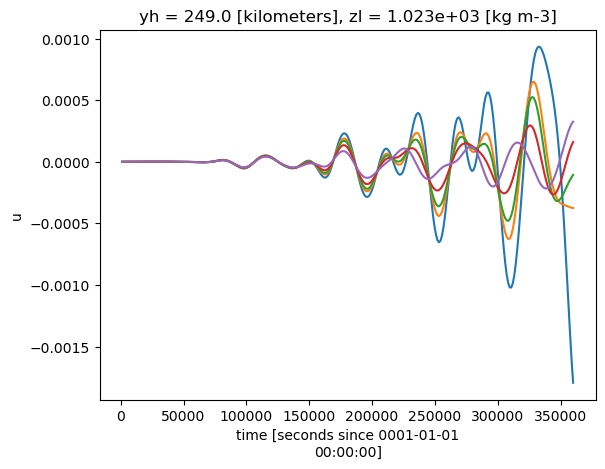

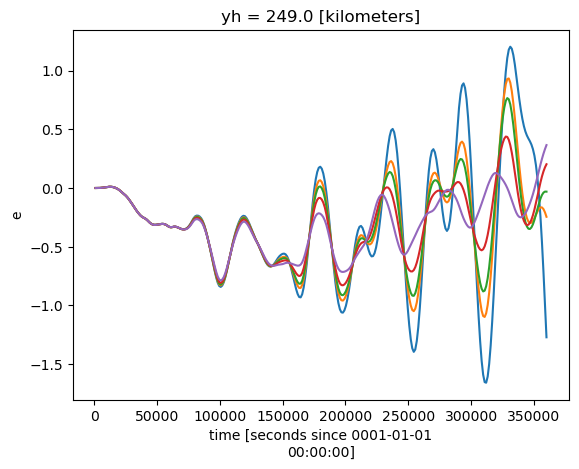

In [23]:
for i in range(5):
    ((u - ufar) * (pEast - pEastFar)).isel(zl = i).sel(yh = 250,method = "nearest").plot()
plt.figure()
for i in range(5):
    ((u - ufar)).isel(zl = i).sel(yh = 250,method = "nearest").plot()
plt.figure()
for i in range(5):
    ((pEast - pEastFar)).isel(zl = i).sel(yh = 250,method = "nearest").plot()